<a href="https://colab.research.google.com/github/abarankab/tinkoff_notebooks/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install tqdm

from tqdm import tqdm
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
%matplotlib inline

tcmalloc: large alloc 1073750016 bytes == 0x57e00000 @  0x7f1eca9962a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation

In [0]:
dataset = datasets.MNIST('mnist', train=True, download=True,
                         transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Processing...
Done!


In [0]:
device = torch.device('cuda:0')
torch.cuda.is_available()

True

In [0]:
class Reshape(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape
  
  def forward(self, input):
    return input.view(input.shape[0], *self.shape)
    

class Printer(nn.Module):
  def __init__(self):
    super().__init__()
    
  def forward(self, input):
    print(input[0].shape)
    return input

In [0]:
HIDDEN_STATE = 14
BETA = -0.048

In [0]:
class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #nn.BatchNorm2d(16),
        
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #nn.BatchNorm2d(32),
        
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #nn.BatchNorm2d(64),
        
        Reshape((-1,)),
        nn.Linear(1600, HIDDEN_STATE * 2),
    )
    
    self.decoder = nn.Sequential(
        nn.Linear(HIDDEN_STATE, 196),
        #nn.BatchNorm1d(196),
        nn.Linear(196, 392),
        #nn.BatchNorm1d(392),
        nn.Linear(392, 784),
        #nn.BatchNorm1d(784),
        Reshape((1, 28, 28,)),
    )
  
    
  def reparameterize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = std.data.new(std.size()).normal_()
    return eps.mul(std).add_(mu)
  
  def forward(self, input):
    result = self.encoder(input)
    mu, logvar = result[:, :14], result[:, 14:]
    z = self.reparameterize(mu, logvar)
    return self.decoder(z), mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def loss_function(recon_x, x, mu, logvar):
  MSE = F.mse_loss(recon_x, x)
  
  #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
  KLD = BETA * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return MSE + KLD

In [0]:
for epoch in range(5):
    train_loss = 0
    for data, _ in tqdm(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        
        train_loss += loss.data[0]
        optimizer.step()
        
    print('epoch %d, loss %.4f' % (epoch, train_loss / len(dataset)))

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
  1%|          | 6/938 [00:00<00:17, 51.86it/s]

epoch 0, loss 0.0011


  1%|          | 5/938 [00:00<00:19, 46.86it/s]

epoch 1, loss 0.0011


  1%|          | 6/938 [00:00<00:18, 51.23it/s]

epoch 2, loss 0.0011


  1%|          | 6/938 [00:00<00:17, 52.33it/s]

epoch 3, loss 0.0011


100%|██████████| 938/938 [00:17<00:00, 52.99it/s]

epoch 4, loss 0.0011


In [0]:
example = model.decoder(torch.randn(64, 14).to(device))

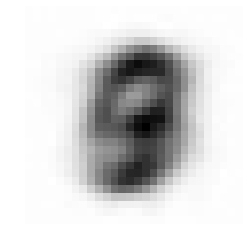

In [0]:
im = example[8].cpu().detach().numpy().astype('float').reshape(28, 28)

plt.axis('off')
plt.imshow(im)

In [0]:
data = None
for q, _ in dataloader:
  print(q.shape)
  data = q.to(device)
  break

torch.Size([64, 1, 28, 28])


In [0]:
dataset = datasets.MNIST('mnist', train=False, download=True,
        transform=transforms.ToTensor())

def get(x):
    return dataset[x][0].view(1, 1, 28, 28)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    latent = [model.encoder(get(k).to(device)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            c = c[:, :14]
            #print(c)
            morphed = model.decoder(c).data
            morphed = morphed.view(28, 28)
            #print(morphed[0])
            morphed = morphed.cpu().detach()
            #print(morphed.mean())
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

In [0]:
!which ffmpeg
plt.rcParams['animation.ffmpeg_path'] = u'/usr/bin/ffmpeg'    

['html']


KeyError: ignored

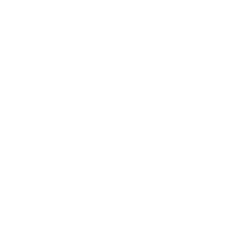

In [0]:
print(animation.writers.list())

morph(np.random.randint(0, len(dataset), 30), 20, 30)

In [0]:
#model = model.eval()
q = torch.randn(1, 14)
print(q)
plt.imshow(model.decoder(q.to(device)).view(28, 28).cpu().detach())

In [0]:
model = model.eval()